In [1]:
library(cowplot)
library(tidyverse)

theme_set(theme_cowplot())
results <- '../results/'

palette_yn <- c('No' = 'gray80', 'Yes' = 'firebrick')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In this notebook, I compare GENESIS and BCAC results. I first read the VEGAS2 scores of the genes.

In [2]:
genes <- inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd'), 
                    read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd'), 
           by = c("Chr", "Gene", "Start", "Stop"),
           suffix = c('_bcac', '_genesis'))

p_bonf_genes = .05 / nrow(genes)
genes <- genes %>%
    mutate(sign_genesis = ifelse(`Top-0.1-pvalue_genesis` < p_bonf_genes, 'Yes', 'No'),
           sign_bcac = ifelse(`Top-0.1-pvalue_bcac` < p_bonf_genes, 'Yes', 'No') )

gene_comparison <- genes %>%
    mutate(significant = (sign_genesis == 'Yes') | (sign_bcac == 'Yes') ) %>%
    ggplot(aes(x = -log10(`Top-0.1-pvalue_genesis`), 
               y = -log10(`Top-0.1-pvalue_bcac`),
               color = ifelse(significant, 'Yes', 'No'))) +
        geom_point() +
        geom_hline(yintercept = -log10(p_bonf_genes), color = 'gray50') +
        geom_vline(xintercept = -log10(p_bonf_genes), color = 'gray50') +
        labs(x = bquote('-log' [10] ~'(P-value' [GENESIS]~')'), 
             y = bquote('-log' [10] ~'(P-value' [BCAC]~')'),
             color = 'Significant', title = '') +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 10),
              axis.title = element_text(size = 12),
              legend.text = element_text(size = 12),
              legend.title = element_text(size = 12)) +
        scale_color_manual(values = palette_yn)

They do not contain exactly the same genes, so the individual Bonferroni thresholds differ.

In [3]:
0.05 / (read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>% nrow)
0.05 / (read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>% nrow)

[1] 1.528444e-06

[1] 1.525925e-06

Hence, when I combine them, the new Bonferroni threshold is slightly higher. I save this data frame for future use.

In [4]:
write_tsv(genes, paste0(results,'bcac/scored_genes.vegas.join_genesis.txt'))
p_bonf_genes

[1] 1.667445e-06

I repeat the process, now at the SNP level, with the P-values of a chi2 test.

In [5]:
snps <- inner_join(
           read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')
p_bonf_snps = .05 / nrow(snps)

snps <- snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No') )

snp_comparison <- snps %>%
    mutate(significant = (sign_genesis == 'Yes') | (sign_bcac == 'Yes') ) %>%
    ggplot(aes(x = -log10(p_genesis), 
               y = -log10(p_bcac),
               color = ifelse(significant, 'Yes', 'No'))) +
        geom_point() +
        geom_hline(yintercept = -log10(p_bonf_snps), color = 'gray50') +
        geom_vline(xintercept = -log10(p_bonf_snps), color = 'gray50') +
        labs(x = bquote('-log' [10] ~'(P-value' [GENESIS]~')'), 
             y = bquote('-log' [10] ~'(P-value' [BCAC]~')'),
             color = 'Significant', title = '') +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 10),
              axis.title = element_text(size = 12),
              legend.text = element_text(size = 12),
              legend.title = element_text(size = 12)) +
        scale_color_manual(values = palette_yn)

In this case, BCAC contains all SNPs on iCOGS before QC in GENESIS. Hence, Bonferroni thresholds won't match either.

In [6]:
0.05 / (read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), col_types = 'icdcddcddd') %>% nrow)
0.05 / (read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), col_types = 'icdcddcddd') %>% nrow)

[1] 2.382791e-07

[1] 2.537002e-07

I will restrict myself only to the common SNPs i.e. SNPs in iCOGS which passed QC in GENESIS.

In [7]:
write_tsv(snps, paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.join_genesis.assoc'))
p_bonf_snps

[1] 2.382791e-07

Let's compare the P-values between both datasets:

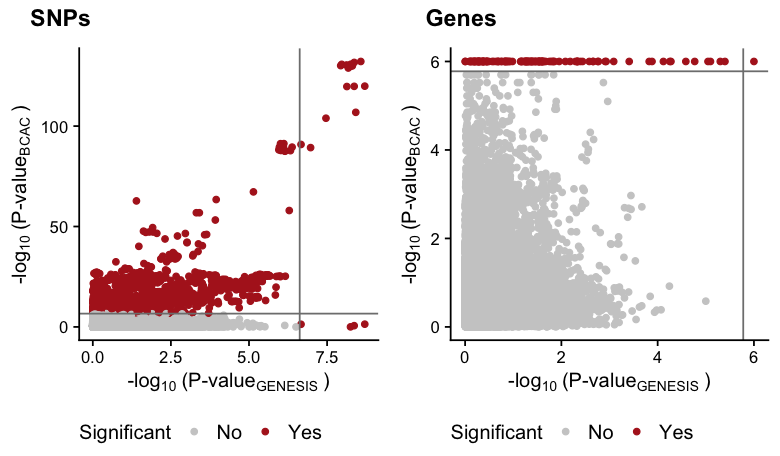

In [8]:
options(repr.plot.width=6.5, repr.plot.height=3.8)
plot_grid(snp_comparison, gene_comparison, labels = c('SNPs', 'Genes'))

In [9]:
select(snps, sign_genesis, sign_bcac) %>% table
select(snps, sign_genesis, sign_bcac) %>% table %>% fisher.test

            sign_bcac
sign_genesis     No    Yes
         No  207809   2008
         Yes      4     17


	Fisher's Exact Test for Count Data

data:  .
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  143.6203 1843.5551
sample estimates:
odds ratio 
  440.6969 


In [10]:
select(genes, sign_genesis, sign_bcac) %>% table
select(genes, sign_genesis, sign_bcac) %>% table %>% fisher.test

            sign_bcac
sign_genesis    No   Yes
         No  29857   128
         Yes     0     1


	Fisher's Exact Test for Count Data

data:  .
p-value = 0.004302
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 5.934468      Inf
sample estimates:
odds ratio 
       Inf 


I create two quantitative variables (significant in BCAC - Y/N - and significant in GENESIS - Y/N). There is a significant imbalance in both cases i.e. more SNPs and genes tend to be significant in both than expected by chance.

# Comparison to BCAC

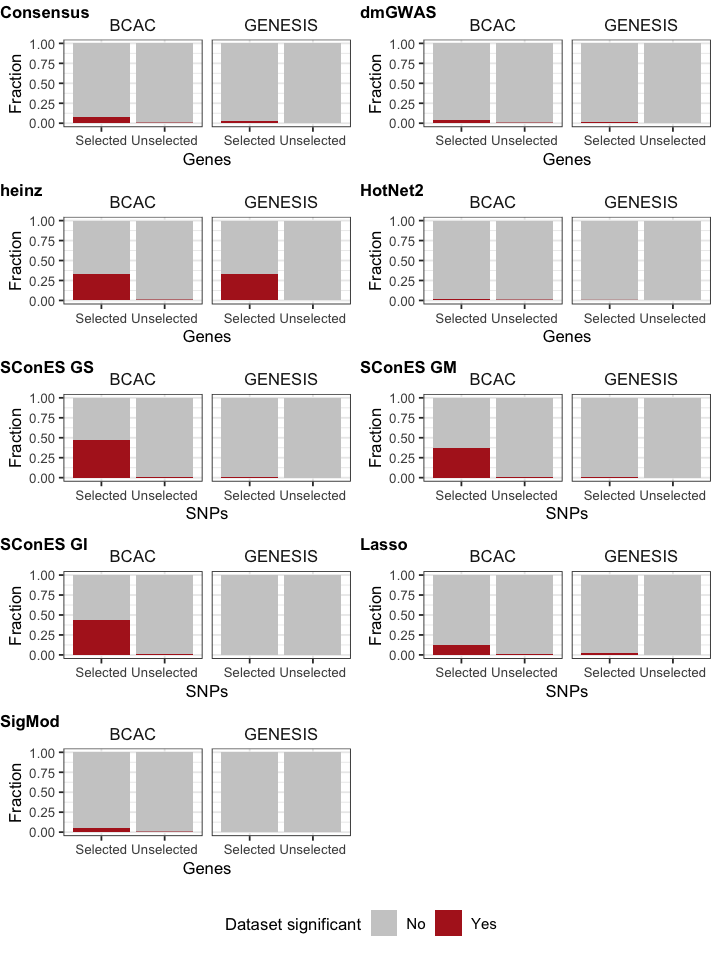

In [11]:
# GENE comparison
# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = 'c')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)

genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)
genes <- inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd'), 
                    read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd'), 
           by = c("Chr", "Gene", "Start", "Stop"),
           suffix = c('_bcac', '_genesis')) %>%
    filter(Gene %in% genes_in_ppi)

plot_selected_genes <- function(genes, selected) {
    
    p_bonf_genes = .05 / nrow(genes)
    
    genes %>%
        mutate(sign_genesis = ifelse(`Top-0.1-pvalue_genesis` < p_bonf_genes, 'Yes', 'No'),
               sign_bcac = ifelse(`Top-0.1-pvalue_bcac` < p_bonf_genes, 'Yes', 'No') ) %>%
        mutate(selected = ifelse(Gene %in% selected, 'Selected', 'Unselected')) %>%
        select(selected, sign_genesis, sign_bcac) %>%
        gather(where, sign, -selected) %>%
        mutate(where = ifelse(where == 'sign_genesis', 'GENESIS', 'BCAC')) %>%
        ggplot(aes(x = selected, fill = sign)) +
            geom_bar(position = 'fill') +
            labs(y = 'Fraction', x = 'Genes') +
            theme_bw() +
            scale_fill_manual(values = palette_yn) +
            facet_wrap(where ~ .) +
            theme(legend.position = 'none',
                  axis.text = element_text(size = 8),
                  axis.title = element_text(size = 10),
                  strip.text = element_text(size = 10),
                  strip.background = element_rect(fill="white", color = 'white'))
    
}

consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllllli')$gene
consensus_bcac <- plot_selected_genes(genes, consensus)

sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
sigmod_bcac <- plot_selected_genes(genes, sigmod)

dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
dmgwas_bcac <- plot_selected_genes(genes, dmgwas)

heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
heinz_bcac <- plot_selected_genes(genes, heinz)

hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'ci')$gene
hotnet2_bcac <- plot_selected_genes(genes, hotnet2)

# scones comparison
snps <- inner_join(
           read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')

plot_selected_snps <- function(snps, selected) {
    
    p_bonf_snps = .05 / nrow(snps)
    
    snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No') ) %>%
    mutate(selected = ifelse(SNP %in% selected, 'Selected', 'Unselected')) %>%
    select(selected, sign_genesis, sign_bcac) %>%
    gather(where, sign, -selected) %>%
    mutate(where = ifelse(where == 'sign_genesis', 'GENESIS', 'BCAC')) %>%
    ggplot(aes(x = selected, fill = sign)) +
        geom_bar(position = 'fill') +
        labs(fill = 'Dataset significant', y = 'Fraction', x = 'SNPs') +
        theme_bw() +
        scale_fill_manual(values = palette_yn) +
        facet_wrap(where ~ .) +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 8),
              axis.title = element_text(size = 10),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 10),
              strip.text = element_text(size = 10),
              strip.background = element_rect(fill="white", color = 'white'))
    
}

gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gs_bcac <- plot_selected_snps(snps, gs)

gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm_bcac <- plot_selected_snps(snps, gm)
legend <- cowplot::get_legend(gm_bcac)

gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gi_bcac <- plot_selected_snps(snps, gi)

lasso <- read_tsv(paste0(results,'lasso/scored_snps.lasso.tsv'), comment = '#', col_types = "cd") %>%
    filter(beta != 0) %>%
    .$snp
lasso_bcac <- plot_selected_snps(snps, lasso)

sf4_no_leg <- plot_grid(consensus_bcac, dmgwas_bcac, 
                        heinz_bcac, hotnet2_bcac,
                        gs_bcac + theme(legend.position="none"), 
                        gm_bcac + theme(legend.position="none"), 
                        gi_bcac + theme(legend.position="none"), 
                        lasso_bcac + theme(legend.position="none"), 
                        sigmod_bcac, ncol = 2, label_size = 10, hjust = 0,
                        labels = c('Consensus', 'dmGWAS', 'heinz', 'HotNet2', 
                                   'SConES GS', 'SConES GM', 'SConES GI', 'Lasso', 'SigMod'))
options(repr.plot.width=6, repr.plot.height=8)
plot_grid(sf4_no_leg, legend, nrow = 2, rel_heights = c(12,1))

Let's put P-values to that, as I did before!

In [12]:
enrichment_test <- function(method, selected) {
    
    p_bonf_genes = .05 / nrow(genes)

    known_bcac_genes <- genes %>%
        filter(`Top-0.1-pvalue_bcac` < p_bonf_genes) %>%
        .$Gene
    
    known_selected <- length(intersect(known_bcac_genes, selected))
    known_not_selected <- length(setdiff(known_bcac_genes, selected))
    unknown_selected <- length(intersect(genes$Gene,selected)) - known_selected
    unknown_not_selected <- length(setdiff(genes$Gene,selected)) - known_not_selected
    recall <- known_selected / length(known_bcac_genes)
    precision <- known_selected / length(selected)

    p <- fisher.test(matrix(c(known_selected,known_not_selected,
                              unknown_selected, unknown_not_selected),
                            nrow = 2), alternative = 'greater')$p.value %>% 
        format(digits = 2)
    
    tibble(method = method, p = p,
           recall = recall,
           precision = precision,
           `BCAC selected`   = known_selected,
           `BCAC unselected` = known_not_selected,
           `Other selected`   = unknown_selected,
           `Other unselected`   = unknown_not_selected)
    
}

enrichment_test_snp <- function(method, selected) {
    
    p_bonf_snps = .05 / nrow(snps)

    known_bcac_snps <- snps %>%
        filter(p_bcac < p_bonf_genes) %>%
        .$SNP
    
    known_selected <- length(intersect(known_bcac_snps, selected))
    known_not_selected <- length(setdiff(known_bcac_snps, selected))
    unknown_selected <- length(intersect(snps$SNP,selected)) - known_selected
    unknown_not_selected <- length(setdiff(snps$SNP,selected)) - known_not_selected
    recall <- known_selected / length(known_bcac_snps)
    precision <- known_selected / length(selected)

    p <- fisher.test(matrix(c(known_selected,known_not_selected,
                              unknown_selected, unknown_not_selected),
                            nrow = 2), alternative = 'greater')$p.value %>% 
        format(digits = 2)
    
    tibble(method = method, p = p, 
           recall = recall,
           precision = precision,
           `BCAC selected`   = known_selected,
           `BCAC unselected` = known_not_selected,
           `Other selected`   = unknown_selected,
           `Other unselected`   = unknown_not_selected)
    
}

enrichment <- list(enrichment_test('dmGWAS', dmgwas), 
                   enrichment_test('heinz', heinz),
                   enrichment_test('HotNet2', hotnet2),
                   enrichment_test_snp('Lasso', lasso),
                   enrichment_test('LEAN', c()),
                   enrichment_test_snp('SConES GS', gs),
                   enrichment_test_snp('SConES GM', gm),
                   enrichment_test_snp('SConES GI', gi),
                   enrichment_test('SigMod', sigmod),
                   enrichment_test('Consensus', consensus)) %>%
    do.call(rbind,.)
enrichment

method,p,recall,precision,BCAC selected,BCAC unselected,Other selected,Other unselected
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
dmGWAS,0.00012,0.094594595,0.03608247,7,67,170,11500
heinz,0.019,0.013513514,0.25000000,1,73,2,11668
HotNet2,0.001,0.121621622,0.02045455,9,65,401,11269
Lasso,7.9e-12,0.006278027,0.14000000,14,2216,84,193520
LEAN,1,0.000000000,NaN,0,74,0,11670
SConES GS,0,0.372197309,0.52201258,830,1400,745,192859
SConES GM,0,0.317040359,0.41784870,707,1523,971,192633
SConES GI,1.3e-259,0.086547085,0.47303922,193,2037,214,193390
SigMod,0.00017,0.081081081,0.04225352,6,68,125,11545


Let's compute the boundaries of precision and recall.

In [13]:
enrichment$recall[! enrichment$method %in% c('SConES GI', 'SConES GS', 'SConES GM', 'LEAN', 'Lasso')] %>% min
enrichment$recall[! enrichment$method %in% c('SConES GI', 'SConES GS', 'SConES GM', 'LEAN', 'Lasso')] %>% max

[1] 0.01351351

[1] 0.1216216

In [14]:
enrichment$precision[! enrichment$method %in% c('SConES GI', 'SConES GS', 'SConES GM', 'LEAN', 'Lasso')] %>% min
enrichment$precision[! enrichment$method %in% c('SConES GI', 'SConES GS', 'SConES GM', 'LEAN', 'Lasso')] %>% max

[1] 0.02045455

[1] 0.25